This script demonstrates why initialization sensitivity is something we are concerned about. We examine a bimodal beta and demonstrate that choice of intial values factors into which mode the VI algorithm finds.

In [75]:
import json
import os
import numpy as np
import jax
import jax.numpy as jnp
from jax.scipy.special import betaln
import numpyro
import numpyro.distributions as dist
from numpyro.infer import SVI, TraceMeanField_ELBO
from numpyro.infer.autoguide import AutoNormal # computes MAP to make family
from numpyro.optim import Adam, Adagrad
import matplotlib.pyplot as plt
from tqdm import tqdm
from bakeoff.posteriors import beta_posterior
from bakeoff.NumPyro.numpyro_svi import run_svi

In [73]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

import numpyro
import numpyro.distributions as dist
from numpyro.infer.util import init_to_value

# ---- Target: *bimodal* Beta mixture on (0,1)
alpha_vec = jnp.array([20.0,  2.0])   # sharp right and sharp left
beta_vec  = jnp.array([ 2.0, 20.0])
mix_probs = jnp.array([0.5, 0.5])

n_samples = 0
y_data = jnp.array([])
n_parallel = 10

# Initializations in *constrained* theta-space (0,1)
# (theta_init, unconstrained_scale)
init_pairs = [
    (0.05, 0.10),  # really tight around left mode
    (0.08, 0.20),  # left-ish, slightly broader
    (0.20, 0.40),  # still left-biased but can slide

    (0.80, 0.40),  # right-biased but can slide
    (0.92, 0.20),  # tight around right mode
    (0.95, 0.10),  # very tight at right boundary
]

def model(y=None):
    components = dist.Beta(alpha_vec, beta_vec)         # vectorized over 2 comps
    mix = dist.MixtureSameFamily(
        mixing_distribution=dist.Categorical(probs=mix_probs),
        component_distribution=components
    )
    theta = numpyro.sample("theta", mix)
    if y is not None:
        numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)

optimizer = Adam(step_size=1e-2)
elbo = TraceMeanField_ELBO(num_particles=100)

# just to have it around; not used below
guide = AutoNormal(model)
def_guide = AutoNormal(model)

posteriors = []   # will store (mu_uncon, sigma_uncon) for plotting

# ------------------------------------------------------------------
# Fit one AutoNormal guide per init, using init_to_value for theta
# and init_scale for unconstrained std.
# ------------------------------------------------------------------
for i, (theta0, sigma0) in enumerate(init_pairs):
    print(f"\nInit {i}: theta_init={theta0}, init_scale={sigma0}")

    temp_guide = AutoNormal(
        model,
        init_loc_fn=init_to_value(values={"theta": jnp.array(theta0)}),
    )#init_scale=sigma0,
    #)
    temp_svi = SVI(model, temp_guide, optimizer, elbo)

    svi_result = temp_svi.run(
        jax.random.PRNGKey(10 + i),
        50_000,   # bump this if you want more convergence; 50k is usually enough
        y=y_data,
    )

    params = svi_result.params

    # Unconstrained guide parameters for theta
    # AutoNormal packs all latents into auto_loc/auto_scale; here it's scalar.
    mu_uncon   = float(np.asarray(params["theta_auto_loc"]))
    sigma_uncon = float(np.asarray(params["theta_auto_scale"]))

    # Draw posterior samples of theta (constrained) just for diagnostics
    temp_samples = temp_guide.sample_posterior(
        jax.random.PRNGKey(100 + i),
        params,
        sample_shape=(2000,),
        y=y_data,
    )
    theta_samps = np.asarray(temp_samples["theta"])
    final_loc   = float(theta_samps.mean())
    final_scale = float(theta_samps.std())

    print(f"  unconstrained: mu={mu_uncon:.3f}, sigma={sigma_uncon:.3f}")
    print(f"  theta (0,1):   mean={final_loc:.3f}, std={final_scale:.3f}")

    # Store unconstrained params for plotting the SigmoidNormal
    posteriors.append((mu_uncon, sigma_uncon))

# ------------------------------------------------------------------
# Densities
# ------------------------------------------------------------------
def beta_mixture_pdf(x, alpha_vec, beta_vec, mix_probs):
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    comps = dist.Beta(alpha_vec, beta_vec)           # vectorized over K components
    log_pdf = comps.log_prob(x[:, None])             # [n_x, K]
    pdf = jnp.exp(log_pdf)                           # [n_x, K]
    return (pdf * mix_probs).sum(axis=1)             # [n_x]

def sigmoidnormal_pdf(x, mu, sigma):
    # y ~ Normal(mu, sigma), x = sigmoid(y)
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    y = jnp.log(x) - jnp.log1p(-x)                   # logit(x)
    norm = dist.Normal(mu, sigma)
    return jnp.exp(norm.log_prob(y)) / (x * (1 - x))

# ---- grid
xs = jnp.linspace(1e-4, 1 - 1e-4, 1000)

# ---- target: mixture-of-Betas
target_pdf = beta_mixture_pdf(xs, alpha_vec, beta_vec, mix_probs)

# ---- VI fits: use *unconstrained* (mu, sigma) from AutoNormal
init_pdfs = []
for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    pdf_i = sigmoidnormal_pdf(xs, mu_uncon, sigma_uncon)
    init_pdfs.append(pdf_i)
    print(f"Plotting init {i}: mu_uncon={mu_uncon:.3f}, sigma_uncon={sigma_uncon:.3f}")



Init 0: theta_init=0.05, init_scale=0.1


100%|██████████| 50000/50000 [00:12<00:00, 3929.30it/s, init loss: 2.5892, avg. loss [47501-50000]: 0.7213]


  unconstrained: mu=-2.561, sigma=0.744
  theta (0,1):   mean=0.087, std=0.063

Init 1: theta_init=0.08, init_scale=0.2


100%|██████████| 50000/50000 [00:13<00:00, 3747.61it/s, init loss: 2.2941, avg. loss [47501-50000]: 0.7209]


  unconstrained: mu=-2.485, sigma=0.773
  theta (0,1):   mean=0.094, std=0.069

Init 2: theta_init=0.2, init_scale=0.4


100%|██████████| 50000/50000 [00:12<00:00, 3878.71it/s, init loss: 3.1820, avg. loss [47501-50000]: 0.7210]


  unconstrained: mu=-2.499, sigma=0.775
  theta (0,1):   mean=0.095, std=0.069

Init 3: theta_init=0.8, init_scale=0.4


100%|██████████| 50000/50000 [00:13<00:00, 3820.71it/s, init loss: 3.2587, avg. loss [47501-50000]: 0.7207]


  unconstrained: mu=2.485, sigma=0.766
  theta (0,1):   mean=0.906, std=0.066

Init 4: theta_init=0.92, init_scale=0.2


100%|██████████| 50000/50000 [00:12<00:00, 3932.05it/s, init loss: 2.2685, avg. loss [47501-50000]: 0.7203]


  unconstrained: mu=2.531, sigma=0.788
  theta (0,1):   mean=0.908, std=0.067

Init 5: theta_init=0.95, init_scale=0.1


100%|██████████| 50000/50000 [00:13<00:00, 3831.53it/s, init loss: 2.4519, avg. loss [47501-50000]: 0.7219]


  unconstrained: mu=2.509, sigma=0.787
  theta (0,1):   mean=0.910, std=0.064
Plotting init 0: mu_uncon=-2.561, sigma_uncon=0.744
Plotting init 1: mu_uncon=-2.485, sigma_uncon=0.773
Plotting init 2: mu_uncon=-2.499, sigma_uncon=0.775
Plotting init 3: mu_uncon=2.485, sigma_uncon=0.766
Plotting init 4: mu_uncon=2.531, sigma_uncon=0.788
Plotting init 5: mu_uncon=2.509, sigma_uncon=0.787


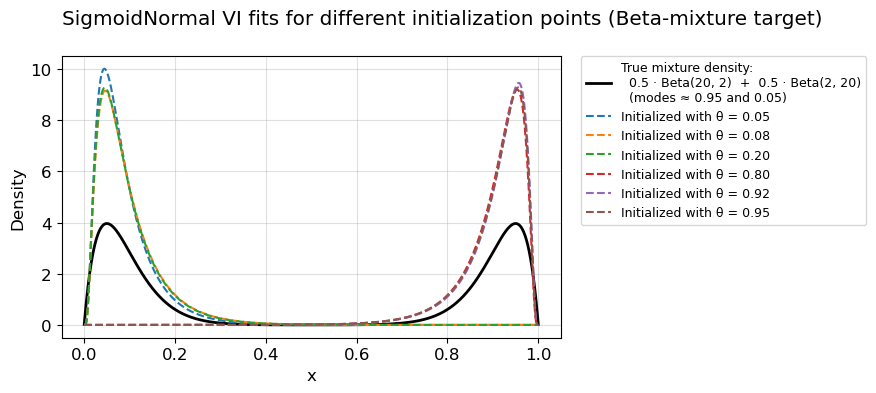

In [74]:
# ---- plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(9, 4))  # wider layout (legend outside)

# Label that shows the *actual* mixture structure
true_label = (
    "True mixture density:\n"
    "  0.5 · Beta(20, 2)  +  0.5 · Beta(2, 20)\n"
    "  (modes ≈ 0.95 and 0.05)"
)

plt.plot(
    np.array(xs),
    np.array(target_pdf),
    label=true_label,
    linewidth=2,
    color='black'
)

# Helper to identify which mode a theta-init is near
def mode_label(theta0):
    return "left-mode init" if theta0 < 0.5 else "right-mode init"

# VI fits with improved labels
for i, pdf_i in enumerate(init_pdfs):
    theta0, sigma0 = init_pairs[i]
    label = f"Initialized with θ = {theta0:.2f}"
    plt.plot(
        np.array(xs),
        np.array(pdf_i),
        linestyle='--',
        linewidth=1.5,
        label=label
    )

plt.xlabel('x')
plt.ylabel('Density')
plt.grid(alpha=0.4)

# Legend fully outside on the right
plt.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

plt.suptitle('SigmoidNormal VI fits for different initialization points (Beta-mixture target)')
plt.tight_layout()
plt.show()




Init 0: theta_init=0.05, init_scale=0.1


100%|██████████| 50000/50000 [00:12<00:00, 4090.48it/s, init loss: 2.5892, avg. loss [47501-50000]: 0.7213]


  unconstrained: mu=-2.561, sigma=0.744
  theta (0,1):   mean=0.087, std=0.063

Init 1: theta_init=0.08, init_scale=0.2


100%|██████████| 50000/50000 [00:12<00:00, 4140.41it/s, init loss: 1.6250, avg. loss [47501-50000]: 0.7209]


  unconstrained: mu=-2.485, sigma=0.773
  theta (0,1):   mean=0.094, std=0.069

Init 2: theta_init=0.2, init_scale=0.4


100%|██████████| 50000/50000 [00:12<00:00, 4093.50it/s, init loss: 1.9505, avg. loss [47501-50000]: 0.7210]


  unconstrained: mu=-2.499, sigma=0.775
  theta (0,1):   mean=0.095, std=0.069

Init 3: theta_init=0.8, init_scale=0.4


100%|██████████| 50000/50000 [00:12<00:00, 4143.98it/s, init loss: 2.1590, avg. loss [47501-50000]: 0.7207]


  unconstrained: mu=2.485, sigma=0.766
  theta (0,1):   mean=0.906, std=0.066

Init 4: theta_init=0.92, init_scale=0.2


100%|██████████| 50000/50000 [00:12<00:00, 4121.96it/s, init loss: 1.6001, avg. loss [47501-50000]: 0.7203]


  unconstrained: mu=2.531, sigma=0.788
  theta (0,1):   mean=0.908, std=0.067

Init 5: theta_init=0.95, init_scale=0.1


100%|██████████| 50000/50000 [00:12<00:00, 3966.81it/s, init loss: 2.4519, avg. loss [47501-50000]: 0.7219]


  unconstrained: mu=2.509, sigma=0.787
  theta (0,1):   mean=0.910, std=0.064


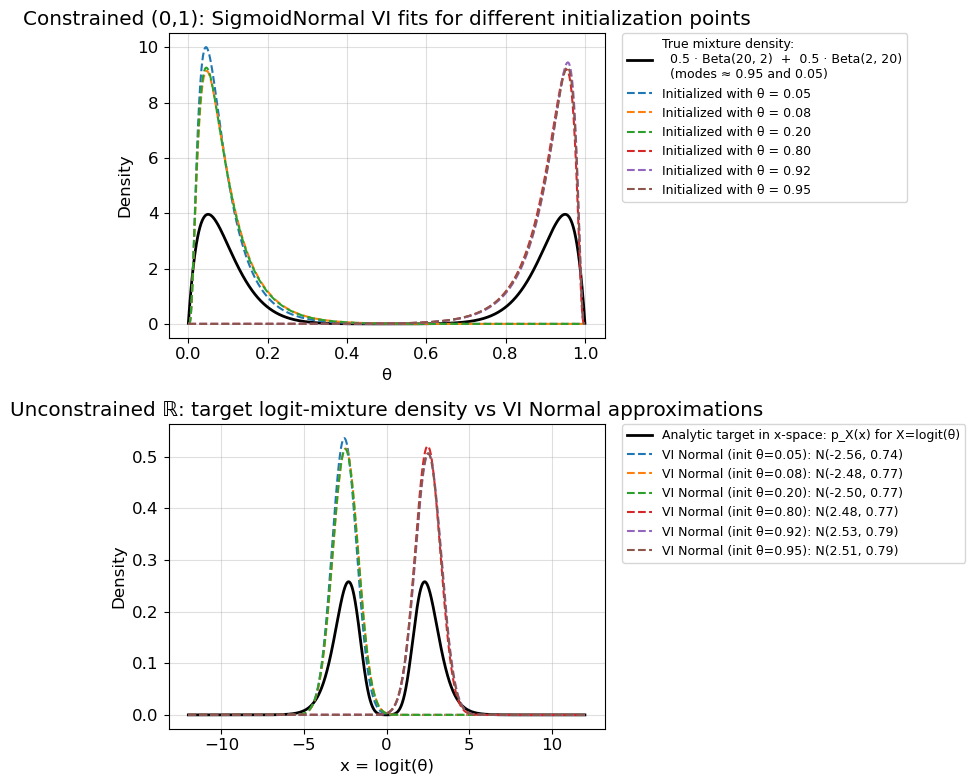

In [81]:

# ---- Target: *bimodal* Beta mixture on (0,1)
alpha_vec = jnp.array([20.0,  2.0])   # sharp right and sharp left
beta_vec  = jnp.array([ 2.0, 20.0])
mix_probs = jnp.array([0.5, 0.5])

n_samples = 0
y_data = jnp.array([])

# Initializations in *constrained* theta-space (0,1)
# (theta_init, unconstrained_scale)
init_pairs = [
    (0.05, 0.10),  # really tight around left mode
    (0.08, 0.20),  # left-ish, slightly broader
    (0.20, 0.40),  # still left-biased but can slide

    (0.80, 0.40),  # right-biased but can slide
    (0.92, 0.20),  # tight around right mode
    (0.95, 0.10),  # very tight at right boundary
]

def model(y=None):
    components = dist.Beta(alpha_vec, beta_vec)         # vectorized over 2 comps
    mix = dist.MixtureSameFamily(
        mixing_distribution=dist.Categorical(probs=mix_probs),
        component_distribution=components
    )
    theta = numpyro.sample("theta", mix)
    if y is not None:
        numpyro.sample("obs", dist.Binomial(n_samples, theta), obs=y)

optimizer = Adam(step_size=1e-2)
elbo = TraceMeanField_ELBO(num_particles=100)

posteriors = []   # will store (mu_uncon, sigma_uncon) for plotting

# ------------------------------------------------------------------
# Fit one AutoNormal guide per init, using init_to_value for theta
# ------------------------------------------------------------------
for i, (theta0, sigma0) in enumerate(init_pairs):
    print(f"\nInit {i}: theta_init={theta0}, init_scale={sigma0}")

    temp_guide = AutoNormal(
        model,
        init_loc_fn=init_to_value(values={"theta": jnp.array(theta0)}),
        init_scale=sigma0,   # preserve your "unconstrained_scale" intent
    )
    temp_svi = SVI(model, temp_guide, optimizer, elbo)

    svi_result = temp_svi.run(
        jax.random.PRNGKey(10 + i),
        50_000,
        y=y_data,
    )

    params = svi_result.params

    mu_uncon    = float(np.asarray(params["theta_auto_loc"]))
    sigma_uncon = float(np.asarray(params["theta_auto_scale"]))

    # diagnostic constrained samples
    temp_samples = temp_guide.sample_posterior(
        jax.random.PRNGKey(100 + i),
        params,
        sample_shape=(2000,),
        y=y_data,
    )
    theta_samps = np.asarray(temp_samples["theta"])
    final_loc   = float(theta_samps.mean())
    final_scale = float(theta_samps.std())

    print(f"  unconstrained: mu={mu_uncon:.3f}, sigma={sigma_uncon:.3f}")
    print(f"  theta (0,1):   mean={final_loc:.3f}, std={final_scale:.3f}")

    posteriors.append((mu_uncon, sigma_uncon))

# ------------------------------------------------------------------
# Densities
# ------------------------------------------------------------------
def beta_mixture_pdf(theta, alpha_vec, beta_vec, mix_probs):
    theta = jnp.clip(theta, 1e-12, 1 - 1e-12)
    comps = dist.Beta(alpha_vec, beta_vec)           # vectorized over K components
    log_pdf = comps.log_prob(theta[:, None])         # [n, K]
    pdf = jnp.exp(log_pdf)                           # [n, K]
    return (pdf * mix_probs).sum(axis=1)             # [n]

def sigmoidnormal_pdf(theta, mu, sigma):
    # If X ~ Normal(mu, sigma), Theta = sigmoid(X)
    theta = jnp.clip(theta, 1e-12, 1 - 1e-12)
    x = jnp.log(theta) - jnp.log1p(-theta)           # logit(theta)
    norm = dist.Normal(mu, sigma)
    return jnp.exp(norm.log_prob(x)) / (theta * (1 - theta))

def beta_mixture_logit_pdf(x, alpha_vec, beta_vec, mix_probs):
    # X = logit(Theta), Theta ~ mixture on (0,1)
    theta = jax.nn.sigmoid(x)
    p_theta = beta_mixture_pdf(theta, alpha_vec, beta_vec, mix_probs)
    jac = theta * (1.0 - theta)                      # d/dx sigmoid(x)
    return p_theta * jac

# ---- grids
theta_grid = jnp.linspace(1e-4, 1 - 1e-4, 1000)
x_grid = jnp.linspace(-12.0, 12.0, 2000)  # covers logit of modes ~ logit(0.05)≈-2.94 and logit(0.95)≈+2.94

# ---- target densities
target_theta_pdf = beta_mixture_pdf(theta_grid, alpha_vec, beta_vec, mix_probs)
target_x_pdf = beta_mixture_logit_pdf(x_grid, alpha_vec, beta_vec, mix_probs)

# ---- VI fits
vi_theta_pdfs = []
vi_x_pdfs = []
for i, (mu_uncon, sigma_uncon) in enumerate(posteriors):
    vi_theta_pdfs.append(sigmoidnormal_pdf(theta_grid, mu_uncon, sigma_uncon))
    vi_x_pdfs.append(jnp.exp(dist.Normal(mu_uncon, sigma_uncon).log_prob(x_grid)))

# ------------------------------------------------------------------
# Final figure: 2 vertical subplots
#   Top: constrained (as you had it)
#   Bottom: unconstrained reals with analytic pushforward of mixture + VI normals
# ------------------------------------------------------------------
plt.rcParams.update({'font.size': 12})
fig, axes = plt.subplots(2, 1, figsize=(9, 8), sharex=False)

# ---------------- Top: constrained support (keep as-is style) ----------------
ax = axes[0]

true_label = (
    "True mixture density:\n"
    "  0.5 · Beta(20, 2)  +  0.5 · Beta(2, 20)\n"
    "  (modes ≈ 0.95 and 0.05)"
)
ax.plot(np.array(theta_grid), np.array(target_theta_pdf),
        label=true_label, linewidth=2, color='black')

for i, pdf_i in enumerate(vi_theta_pdfs):
    theta0, sigma0 = init_pairs[i]
    label = f"Initialized with θ = {theta0:.2f}"
    ax.plot(np.array(theta_grid), np.array(pdf_i),
            linestyle='--', linewidth=1.5, label=label)

ax.set_xlabel('θ')
ax.set_ylabel('Density')
ax.grid(alpha=0.4)
ax.set_title('Constrained (0,1): SigmoidNormal VI fits for different initialization points')

ax.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

# ---------------- Bottom: unconstrained real line ----------------
ax2 = axes[1]

ax2.plot(np.array(x_grid), np.array(target_x_pdf),
         linewidth=2, color='black',
         label="Analytic target in x-space: p_X(x) for X=logit(θ)")

for i, pdf_i in enumerate(vi_x_pdfs):
    theta0, sigma0 = init_pairs[i]
    mu_uncon, sigma_uncon = posteriors[i]
    label = f"VI Normal (init θ={theta0:.2f}): N({mu_uncon:.2f}, {sigma_uncon:.2f})"
    ax2.plot(np.array(x_grid), np.array(pdf_i),
             linestyle='--', linewidth=1.5, label=label)

ax2.set_xlabel('x = logit(θ)')
ax2.set_ylabel('Density')
ax2.grid(alpha=0.4)
ax2.set_title('Unconstrained ℝ: target logit-mixture density vs VI Normal approximations')

ax2.legend(
    bbox_to_anchor=(1.04, 1),
    loc="upper left",
    borderaxespad=0.,
    fontsize=9
)

plt.tight_layout()
plt.show()


In [30]:
# # correct the posteriors
# new_posteriors = []
# for i in range(len(posteriors)):
#     loc, scale = posteriors[i][0][-1], posteriors[i][1][-1]
#     new_posteriors.append((loc, scale))
# posteriors = new_posteriors

In [ ]:

def beta_mixture_pdf(x, alpha_vec, beta_vec, mix_probs):
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    comps = dist.Beta(alpha_vec, beta_vec)           # vectorized over K components
    log_pdf = comps.log_prob(x[:, None])             # [n_x, K]
    pdf = jnp.exp(log_pdf)                           # [n_x, K]
    return (pdf * mix_probs).sum(axis=1)             # [n_x]

def sigmoidnormal_pdf(x, mu, sigma):
    # y ~ Normal(mu, sigma), x = sigmoid(y)
    x = jnp.clip(x, 1e-6, 1 - 1e-6)
    y = jnp.log(x) - jnp.log1p(-x)                   # logit(x)
    norm = dist.Normal(mu, sigma)
    return jnp.exp(norm.log_prob(y)) / (x * (1 - x))

# ---- grid
xs = jnp.linspace(1e-4, 1 - 1e-4, 1000)

# ---- target: mixture-of-Betas (assumes you already defined alpha_vec, beta_vec, mix_probs)
target_pdf = beta_mixture_pdf(xs, alpha_vec, beta_vec, mix_probs)



init_pdfs = []
for i in range(len(posteriors)):
    mu_a, sig_a = posteriors[i]
    init_pdfs.append(sigmoidnormal_pdf(xs, mu_a, sig_a))
    print(f"Init {i}: mu = {mu_a:.3f}, sigma = {sig_a:.3f}")
# guide_a_pdf = sigmoidnormal_pdf(xs, mu_a, sig_a)

# ---- plot
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(7,4))
plt.plot(np.array(xs), np.array(target_pdf), label='True Posterior: Beta Mixture', linewidth=2)
for i in range(len(init_pdfs)):
    plt.plot(np.array(xs), np.array(init_pdfs[i]), '--', label=f'SigmoidNormal Init at {init_pairs[i]}')
# plt.plot(np.array(xs), np.array(guide_a_pdf), '--', label='SigmoidNormal Initialized at (2, 0.7)')
# plt.plot(np.array(xs), np.array(def_guide_pdf), '--', label='Default AutoNormal guide')

plt.xlabel('x')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(0.0, 1.0), loc='upper left')
plt.grid()
plt.suptitle('Default and manual initialization of SigmoidNormal approximations to Beta Mixture')
plt.show()


Init 0: mu = 0.192, sigma = 0.053
Init 1: mu = 0.204, sigma = 0.084
Init 2: mu = 0.248, sigma = 0.154
Init 3: mu = 0.764, sigma = 0.148
Init 4: mu = 0.795, sigma = 0.084
Init 5: mu = 0.809, sigma = 0.055
Init 6: mu = 0.570, sigma = 0.280


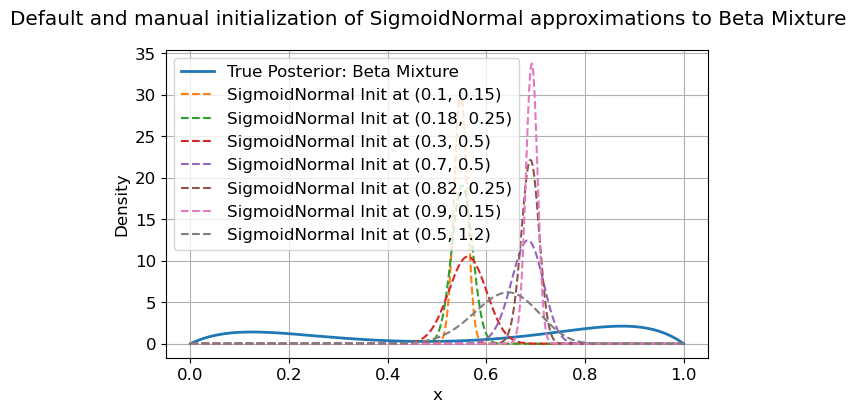

Fitted normal on logit scale: mu = -0.020, sigma = 6.309


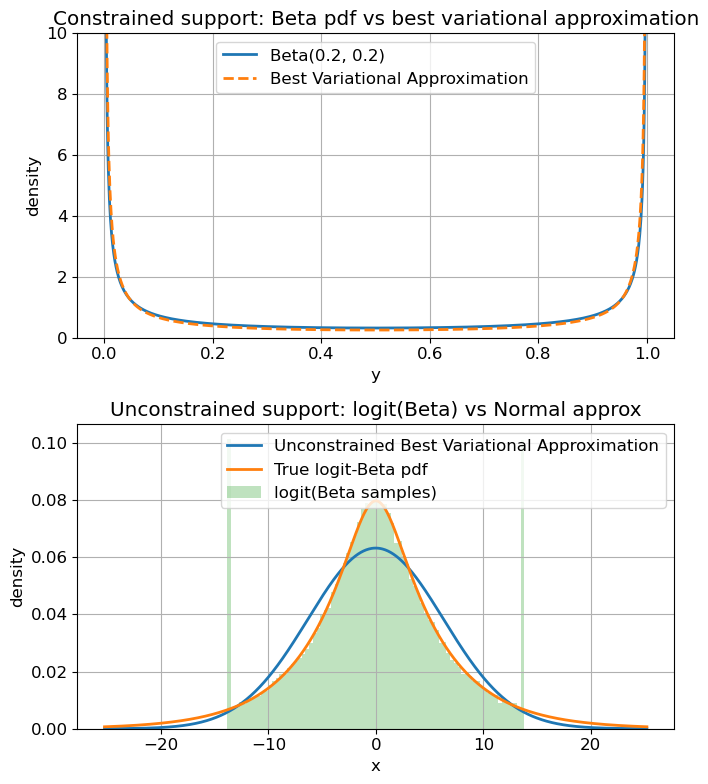

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta, norm
from scipy.special import expit, logit

# 1. Choose a Beta with heavy mass near 0 and 1
alpha, beta_param = 0.2, 0.2   # U-shaped

rng = np.random.default_rng(123)
n_samples = 100_000
y_samples_raw = rng.beta(alpha, beta_param, size=n_samples)

# IMPORTANT: clip away from 0 and 1 to avoid logit(0) = -inf, logit(1) = +inf
eps = 1e-6
y_samples = np.clip(y_samples_raw, eps, 1 - eps)

# 2. Map to x = logit(y) and fit a normal
x_samples = logit(y_samples)

mu_hat = x_samples.mean()
sigma_hat = x_samples.std(ddof=1)
print(f"Fitted normal on logit scale: mu = {mu_hat:.3f}, sigma = {sigma_hat:.3f}")

# 3. Grids for plotting
y_grid = np.linspace(1e-4, 1 - 1e-4, 1000)  # avoid exact 0 and 1
x_grid = np.linspace(mu_hat - 4 * sigma_hat, mu_hat + 4 * sigma_hat, 1000)

# 4. Beta pdf on (0,1)
beta_pdf = beta.pdf(y_grid, alpha, beta_param)

# 5. Logistic-normal pdf induced by X ~ N(mu_hat, sigma_hat^2) and Y = sigmoid(X)
logit_y = logit(y_grid)
px_logit_y = norm.pdf(logit_y, loc=mu_hat, scale=sigma_hat)
jacobian = 1.0 / (y_grid * (1.0 - y_grid))
logistic_normal_pdf = px_logit_y * jacobian

# 6. Fitted normal pdf on x
normal_pdf_x = norm.pdf(x_grid, loc=mu_hat, scale=sigma_hat)

# also 6. logit-Beta pdf on x with a smooth curve
y_from_x = expit(x_grid)
logit_beta_pdf_x = beta.pdf(y_from_x, alpha, beta_param) * (y_from_x * (1 - y_from_x))

# 7. Plot: Beta vs induced logistic-normal on (0,1)
fig, axes = plt.subplots(2, 1, figsize=(7, 8), sharex=False)

# ---------- (1) Constrained Plot: Beta vs SigmoidNormal ----------
ax = axes[0]
ax.plot(y_grid, beta_pdf, label=f"Beta({alpha}, {beta_param})", linewidth=2)
ax.plot(y_grid, logistic_normal_pdf, "--",
        label="Best Variational Approximation", linewidth=2)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Constrained support: Beta pdf vs best variational approximation")
ax.legend()
ax.set_ylim(0, 10)
ax.grid(True)

# ---------- (2) Unconstrained Plot: logit(Beta) vs Normal vs histogram of logit(Beta samples)----------
ax2 = axes[1]
ax2.plot(x_grid, normal_pdf_x, linewidth=2,
         label="Unconstrained Best Variational Approximation")
ax2.plot(x_grid, logit_beta_pdf_x, linewidth=2,
         label="True logit-Beta pdf")  # <-- added smooth curve
ax2.hist(x_samples, bins=80, density=True, alpha=0.3,
         label="logit(Beta samples)")
ax2.set_xlabel("x")
ax2.set_ylabel("density")
ax2.set_title("Unconstrained support: logit(Beta) vs Normal approx")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


